https://youtu.be/nCMDZEScF-4

**Nuclei segmentation in whole slide H&E images**

using custom model.

This is pretty much all taken from Dr. Sreenivas Bhattiprolu's github:
https://github.com/bnsreenu/python_for_microscopists/blob/master/281_Segmenting_WSI_using_StarDist.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imsave
from csbdeep.utils import Path, normalize
from csbdeep.utils.tf import keras_import
keras = keras_import()

from stardist import export_imagej_rois, random_label_cmap
from stardist.models import StarDist2D

np.random.seed(0)
cmap = random_label_cmap()

In [2]:
def show_image(img, crop_x, crop_y, tile_size, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(img, **kwargs)

    # Crop the image
    cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

    # Plot the cropped image on the right
    ax[1].imshow(cropped_img, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [5]:
import os
from glob import glob

pth = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles'  # path of ndpi files
WSIs = sorted(glob(r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\*.ndpi'))

pth_mat = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\10x\matfiles'
crop_mats = [_ for _ in os.listdir(pth_mat) if _.endswith('mat')]

In [7]:
WSIs

['\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\1024tiles\\monkey_fetus_40_0105_ecm.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\1024tiles\\monkey_fetus_40_0271_eye.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\1024tiles\\monkey_fetus_40_0400_spinalcord.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\1024tiles\\monkey_fetus_40_0420_brain.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\1024tiles\\monkey_fetus_40_0432_bone.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\1024tiles\\monkey_fetus_40_0450_heart.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\1024tiles\\monkey_fetus_40_0730_kidney.ndpi']

In [11]:
imgs[0]

(29568, 32640, 3)

In [14]:
from csbdeep.utils import normalize
import sys
from tqdm import tqdm

# you might need to run "pip install imagecodecs" if you get jpeg compression error

imgs = list(map(imread, WSIs))
n_channel = 1 if imgs[0].ndim == 2 else imgs[0].shape[-1]  #If no third

# axis_norm = (0,1)   # normalize channels independently
axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

imgs = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(imgs)]

Normalizing image channels jointly.


100%|██████████| 7/7 [03:23<00:00, 29.14s/it]


In [15]:
WSIs

['\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\1024tiles\\monkey_fetus_40_0105_ecm.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\1024tiles\\monkey_fetus_40_0271_eye.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\1024tiles\\monkey_fetus_40_0400_spinalcord.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\1024tiles\\monkey_fetus_40_0420_brain.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\1024tiles\\monkey_fetus_40_0432_bone.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\1024tiles\\monkey_fetus_40_0450_heart.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\1024tiles\\monkey_fetus_40_0730_kidney.ndpi']

In [16]:
for img in imgs:
    print(img.shape)

(29568, 32640, 3)
(30976, 36480, 3)
(29568, 36480, 3)
(30976, 36480, 3)
(28160, 34560, 3)
(28160, 36480, 3)
(25344, 36480, 3)


In [17]:
from scipy.io import loadmat

def get_crop_info(crop_mat_file_path, ratio) -> tuple:
    data = loadmat(crop_mat_file_path)

    offset = 1024/4 + 1024/8
    crop_width = 256
    crop_height = 256
    crop_x = int(data['crop_x']*ratio + offset)
    crop_y = int(data['crop_y']*ratio)

    return (crop_x, crop_y, crop_width)



In [18]:
ind = 0

mat_file_path = os.path.join(pth_mat, crop_mats[ind])
res20x=0.4416
res10x=1
ratio = res10x/res20x

crop_x, crop_y, tile_size = crop_info = get_crop_info(mat_file_path, ratio)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


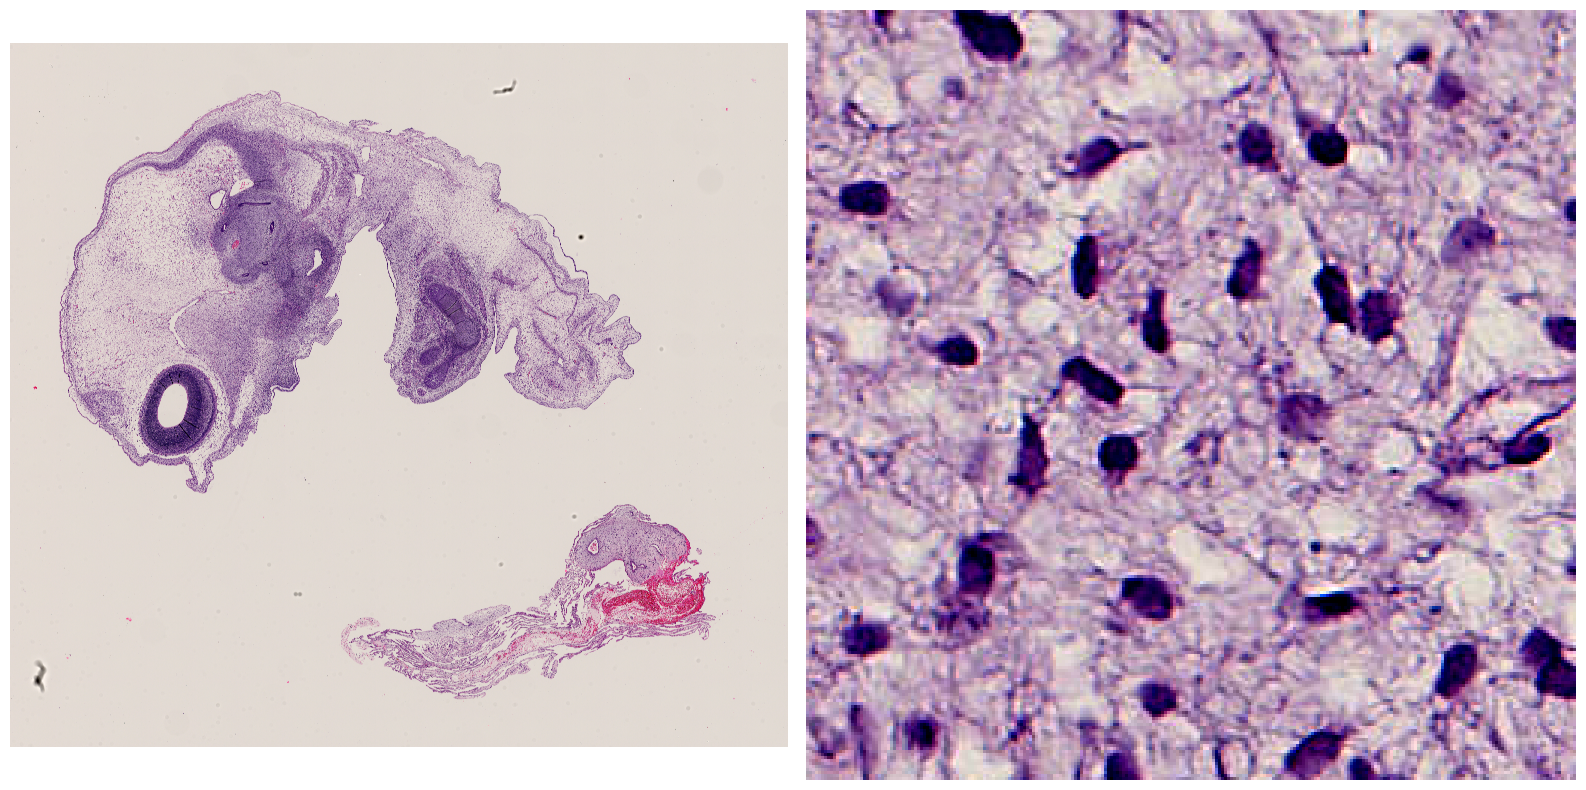

In [19]:
show_image(imgs[ind], crop_x, crop_y, tile_size)

In [20]:
model = StarDist2D(None, name='monkey_tile_trained', basedir=r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\stardist_models')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.593187, nms_thresh=0.3.


In [21]:
def show_image(img, crop_x, crop_y, tile_size, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(img, **kwargs)

    # Crop the image
    cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

    # Plot the cropped image on the right
    ax[1].imshow(cropped_img, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [22]:
#Slow - takes time to segment the large image

img = imgs[ind]

labels, polys = model.predict_instances_big(img, axes='YXC', block_size=4096, min_overlap=128, context=128, n_tiles=(4,4,1))

effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 72/72 [02:18<00:00,  1.93s/it]


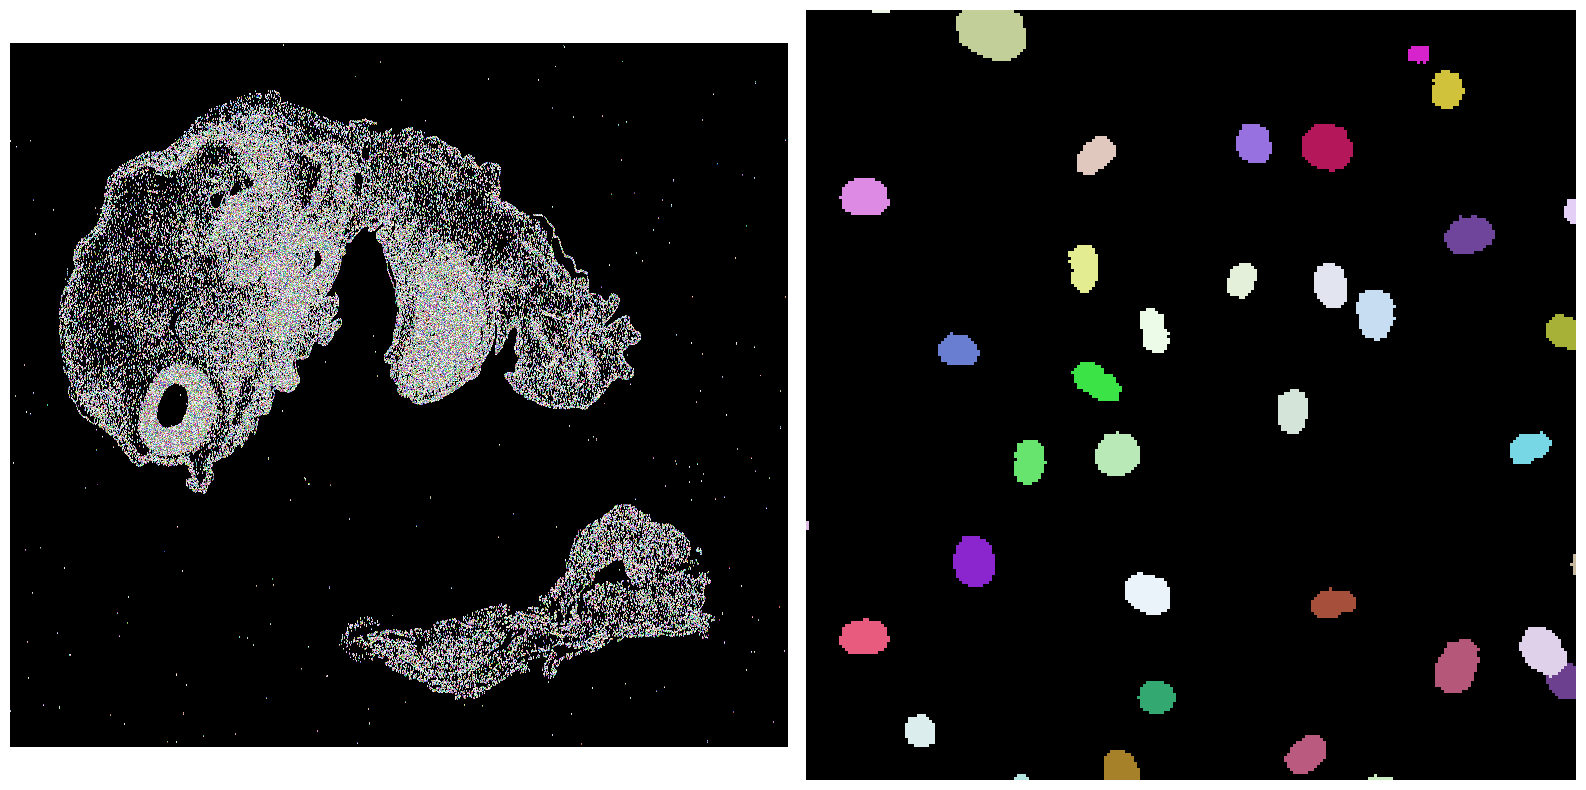

In [23]:
show_image(labels, crop_x, crop_y, tile_size, cmap=cmap)